<a href="https://colab.research.google.com/github/polo-music/test_tma/blob/main/test_tma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('classic')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving CATB - CATB.csv to CATB - CATB.csv


In [100]:
df = pd.read_csv('CATB - CATB.csv')
#cargamos el data frame
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
df_2 = df.tail(200)
#utilitzarem el dataframe 2 per test amb les primeres x dades
#l'index és la data
df_2 = df_2.set_index(pd.DatetimeIndex(df_2['Date'].values))
#quitar $ de las columnas
#definir el rango de valores y quitar $ de la primera posición
for i in range(0, len(df_2)):
  v = df_2.iat[i, 1]
  #definimos variable para quitar el $
  #print(v.strip('$'))
  v = v.strip('$')
  #añadimos la nueva columna con los datos sin $ en el dataframe
  df_2.iat[i, 1] = pd.to_numeric(v)

#ahora tenemos el dataset 2 con la columna close/last sin el $
print(df_2)

                  Date Close/Last     Volume   Open    High      Low
2020-04-16  04/16/2020       5.29     122025  $5.18    $5.4    $5.15
2020-04-17  04/17/2020       5.45      88390  $5.41   $5.56     $5.3
2020-04-20  04/20/2020       5.31     146507  $5.43   $5.54    $5.24
2020-04-21  04/21/2020       5.01     127877  $5.19   $5.28    $4.82
2020-04-22  04/22/2020        5.1     113803  $5.09   $5.26    $4.99
...                ...        ...        ...    ...     ...      ...
2021-01-25  01/25/2021       2.75     906678  $2.75   $2.84    $2.61
2021-01-26  01/26/2021       2.65     845353  $2.78   $2.82  $2.6201
2021-01-27  01/27/2021       2.51    1100405  $2.58   $2.65    $2.45
2021-01-28  01/28/2021       2.43     901958  $2.51  $2.551    $2.35
2021-01-29  01/29/2021       4.15  287175000   $3.6   $7.97    $3.12

[200 rows x 6 columns]


In [101]:
#test algoritmo three moving avarage
#short fast moving avarage

#ahora podemos definir los indices ya que la funcion ewm exponential weight mean solo trabaja con int
shortEMA = df_2['Close/Last'].ewm(span=5, adjust = False).mean()

#definimos la funcion ewm a medio y largo plazo
middleEMA = df_2['Close/Last'].ewm(span=25, adjust = False).mean()
largeEMA = df_2['Close/Last'].ewm(span=50, adjust = False).mean()

In [115]:
#agragamos al datafram tres columnas con los exponential moving averages
df_2['Short EMA'] = shortEMA
df_2['Middle EMA'] = middleEMA
df_2['Large EMA'] = largeEMA

df_2

,Date,Close/Last,Volume,Open,High,Low,Short EMA,Middle EMA,Large EMA,Comprar,Vender
2020-04-16,04/16/2020,5.29,122025,$5.18,$5.4,$5.15,5.290000,5.290000,5.290000,NaN,NaN
2020-04-17,04/17/2020,5.45,88390,$5.41,$5.56,$5.3,5.343333,5.302308,5.296275,5.45,NaN
2020-04-20,04/20/2020,5.31,146507,$5.43,$5.54,$5.24,5.332222,5.302899,5.296813,NaN,NaN
2020-04-21,04/21/2020,5.01,127877,$5.19,$5.28,$4.82,5.224815,5.280369,5.285565,5.01,NaN
2020-04-22,04/22/2020,5.1,113803,$5.09,$5.26,$4.99,5.183210,5.266494,5.278288,NaN,5.10
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,01/25/2021,2.75,906678,$2.75,$2.84,$2.61,2.693626,2.433465,2.570995,NaN,NaN
2021-01-26,01/26/2021,2.65,845353,$2.78,$2.82,$2.6201,2.679084,2.450122,2.574093,NaN,NaN
2021-01-27,01/27/2021,2.51,1100405,$2.58,$2.65,$2.45,2.622723,2.454728,2.571580,NaN,NaN
2021-01-28,01/28/2021,2.43,901958,$2.51,$2.551,$2.35,2.558482,2.452826,2.566028,2.43,NaN


In [116]:
#definimos la funcion para comprar y vender acciones, que usa una sola variable de datos

def compra_venta(data):
  
  vender = []
  comprar = []
  #listas para decidir si comprar o vender, si existe la lista con una señal de vender y
  #le llega otra de vender, debera vender primero la que ya tiene

  #avisos para señal de movimiento (de comprar o vender) para saber en que punto de la operación estamos
  #si tenemos señal de compra primero vender antes de comprar y si llegamos a la señal de venta sabemos que
  #hay que comprar antes de vender
  slarga = False
  scorta = False

  #loop sobre todo el dataframe
  for i in range(0, len(data)):
    #estrategia 1: si la media exponencial middle de un punto (dia) i del dataframe es inferior a la media exponencial
    #larga del mismo dia i y la media corta es inferior a la media middle se vende, y si las dos señales son false
    if data['Short EMA'][i] < data['Large EMA'][i] and data['Short EMA'][i] < data['Middle EMA'][i] and scorta == False:
      #si se cumplen todas estas condiciones comprar (añadir a la lista de compras el dia que deberiamos haber comprado)
      comprar.append(data['Close/Last'][i])
      #no añadir nada a la lista de vender pero mantener las posiciones de las dos listas parejas
      vender.append(np.nan)
      scorta = True #para saber que hemos comprado accion
    
    #para vender las acciones que hemos comprado tenemos que haberlas comprado primero (scorta = true) y que la exponencial corta
    #cruze la exponencial media por arriba
    elif scorta == True and data['Short EMA'][i] > data['Middle EMA'][i]:
      comprar.append(np.nan)
      vender.append(data['Close/Last'][i])
      scorta = False

    #lo mismo para la compra en largo
    elif data['Short EMA'][i] > data['Large EMA'][i] and data['Short EMA'][i] > data['Middle EMA'][i] and slarga == False:
      comprar.append(data['Close/Last'][i])
      vender.append(np.nan)
      slarga = True
    
    elif slarga == True and data['Short EMA'][i] < data['Middle EMA'][i]:
      comprar.append(np.nan)
      vender.append(data['Close/Last'][i])
      slarga = False
    #si no se cumple ninguna de las dos opciones de compra venta simplemente que no haga nada
    else:
      comprar.append(np.nan)
      vender.append(np.nan)

  return (comprar, vender)



In [117]:
#agregar al datafreme las columnas de comprar y vender
df_2['Comprar'] = compra_venta(df_2)[0]
df_2['Vender'] = compra_venta(df_2)[1]

df_2

,Date,Close/Last,Volume,Open,High,Low,Short EMA,Middle EMA,Large EMA,Comprar,Vender
2020-04-16,04/16/2020,5.29,122025,$5.18,$5.4,$5.15,5.290000,5.290000,5.290000,NaN,NaN
2020-04-17,04/17/2020,5.45,88390,$5.41,$5.56,$5.3,5.343333,5.302308,5.296275,5.45,NaN
2020-04-20,04/20/2020,5.31,146507,$5.43,$5.54,$5.24,5.332222,5.302899,5.296813,NaN,NaN
2020-04-21,04/21/2020,5.01,127877,$5.19,$5.28,$4.82,5.224815,5.280369,5.285565,5.01,NaN
2020-04-22,04/22/2020,5.1,113803,$5.09,$5.26,$4.99,5.183210,5.266494,5.278288,NaN,5.1
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,01/25/2021,2.75,906678,$2.75,$2.84,$2.61,2.693626,2.433465,2.570995,NaN,NaN
2021-01-26,01/26/2021,2.65,845353,$2.78,$2.82,$2.6201,2.679084,2.450122,2.574093,NaN,NaN
2021-01-27,01/27/2021,2.51,1100405,$2.58,$2.65,$2.45,2.622723,2.454728,2.571580,NaN,NaN
2021-01-28,01/28/2021,2.43,901958,$2.51,$2.551,$2.35,2.558482,2.452826,2.566028,NaN,NaN


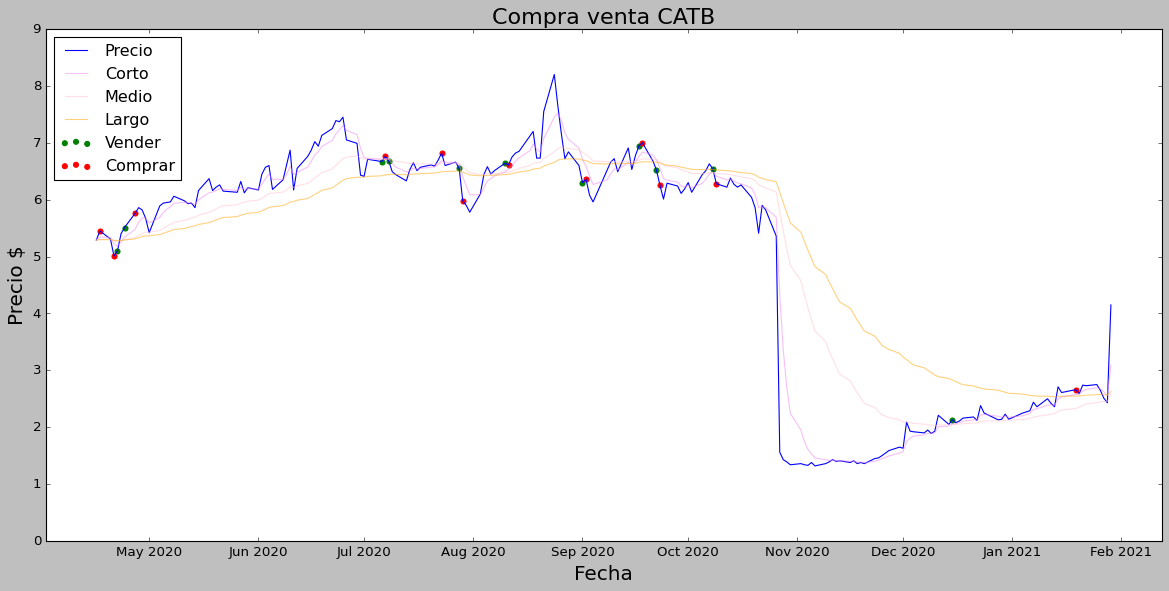

In [118]:
plt.figure(figsize=(18, 8))
plt.title('Compra venta CATB', fontsize = 20)
plt.plot(df_2['Close/Last'], label='Precio', color = 'blue')
plt.plot(shortEMA, label='Corto', color = 'violet', alpha = 0.5)
plt.plot(middleEMA, label = 'Medio', color = 'pink', alpha = 0.5)
plt.plot(largeEMA, label='Largo', color = 'orange', alpha = 0.5)

plt.xlabel('Fecha', fontsize = 18)
plt.ylabel('Precio $', fontsize = 18)
plt.yscale('linear')

plt.scatter(df_2.index, df_2['Vender'], color = 'green', marker = 'o', label = 'Vender')
plt.scatter(df_2.index, df_2['Comprar'], color = 'red', marker = 'o', label = 'Comprar')

plt.legend(loc = 'upper left')
plt.show()